# Cifar 10 AlexNet

## Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import  DataLoader
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Dataset

### CIFAR10 Dataset
For this Project, we'll use the CIFAR10 dataset, which consists of 60000 32x32 px colour images in 10 classes. Here are some sample images from the dataset:
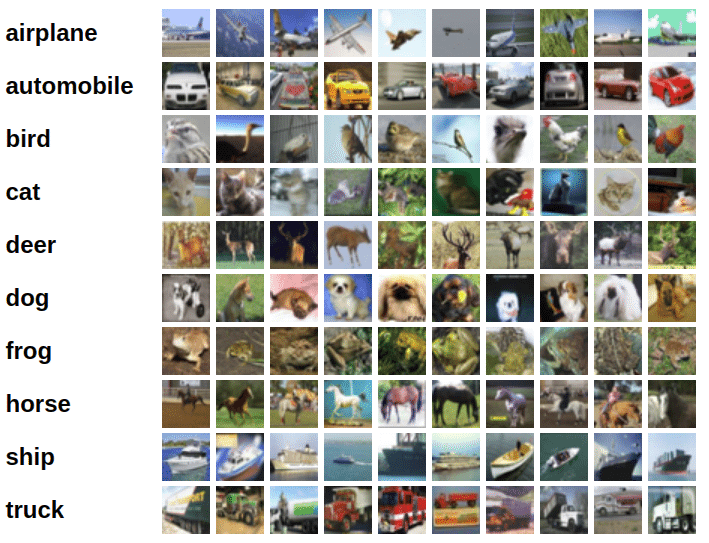

The classes are completely mutually exclusive. There is no overlap between automobiles and trucks. "Automobile" includes sedans, SUVs, and things of that sort. "Truck" includes only big trucks. Neither includes pickup trucks

### Loding Dataset

Using torchvision (a helper library for computer vision tasks), we will load our dataset. This method has some helper functions that makes pre-processing pretty easy and straight-forward. Let's define the functions <code>get_train_valid_loader</Code> and <code>get_test_loader</code>, and then call them to load in and process our CIFAR-10 data:

In [3]:
batchSize = 64

In [4]:
def get_train_valid_loader(data_dir,batch_size,augment,random_seed,valid_size=0.1,shuffle=True):
    normalize = transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010],
    )

    # define transforms
    valid_transform = transforms.Compose([
            transforms.Resize((227,227)),
            transforms.ToTensor(),
            normalize,
    ])
    if augment:
        train_transform = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize,
        ])
    else:
        train_transform = transforms.Compose([
            transforms.Resize((227,227)),
            transforms.ToTensor(),
            normalize,
        ])

    # load the dataset
    train_dataset = torchvision.datasets.CIFAR10(root=data_dir, train=True,download=True, transform=train_transform, )

    valid_dataset = torchvision.datasets.CIFAR10(root=data_dir, train=True, download=True, transform=valid_transform, )

    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, sampler=train_sampler)
 
    valid_loader = torch.utils.data.DataLoader(
        valid_dataset, batch_size=batch_size, sampler=valid_sampler)

    return (train_loader, valid_loader)


def get_test_loader(data_dir,  batch_size, shuffle=True):
    normalize = transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    )

    # define transform
    transform = transforms.Compose([
        transforms.Resize((227,227)),
        transforms.ToTensor(),
        normalize,
    ])

    dataset = torchvision.datasets.CIFAR10(
        root=data_dir, train=False,
        download=True, transform=transform,
    )

    data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=shuffle
    )

    return data_loader

Let's break down the code into bits:

* We define two functions get_train_valid_loader and get_test_loader to load train/validation and test sets respectively

* We start by defining the variable normalize with the mean and standard deviations of each of the channel (red, green, and blue) in the dataset. These can be calculated manually, but are also available online since CIFAR-10 is quite popular

* For our training dataset, we add the option to augment the dataset as well for more robust training and increasing the number of images as well. Note: augmentation is only applied to the training subset and not the validation and testing subsets as they are only used for evaluation purposes

* We split the training dataset into train and validation sets (90:10 ratio), and randomly subset it from the whole training set

* We specify the batch size and shuffle the dataset when loading, so that every batch has some variance in the types of labels it has. This will increase the efficacy of our eventual model

* Finally, we make use of data loaders. This might not affect the performance in the case of a small dataset like CIFAR10, but it can really impede the performance in case of large datasets and is generally considered a good practice. Data loaders allow us to iterate through the data in batches, and the data is loaded while iterating and not all at once in start into your RAM

In [5]:
# CIFAR10 dataset 
train_loader, valid_loader = get_train_valid_loader(data_dir = './Cifar10', batch_size = batchSize, augment = False,random_seed = 1)

test_loader = get_test_loader(data_dir = './Cifar10', batch_size = batchSize)

100%|██████████| 170498071/170498071 [00:02<00:00, 69604317.23it/s]


Extracting ./Cifar10/cifar-10-python.tar.gz to ./Cifar10
Files already downloaded and verified
Files already downloaded and verified


In [6]:
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [7]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [8]:
# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

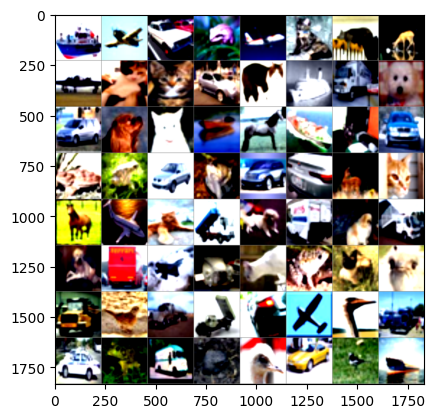

ship  plane car   frog  plane cat   cat   deer  plane cat   cat   car   cat   ship  truck dog   car   dog   cat   ship  horse ship  cat   car   frog  frog  car   frog  car   car   deer  cat   horse plane cat   truck dog   truck dog   truck dog   truck plane car   cat   frog  cat   bird  truck bird  truck truck car   plane bird  truck car   frog  truck frog  bird  car   bird  ship 


In [9]:
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(64)))

## AlexNet

AlexNet is a deep convolutional neural network, which was initially developed by Alex Krizhevsky and his colleagues back in 2012. It was designed to classify images for the ImageNet LSVRC-2010 competition where it achieved state of the art results. You can read in detail about the model in the original research paper here.

The heart of AlexNet is its architecture, comprising five Convolutional (CONV) layers and three Fully Connected (FC) layers. AlexNet opts for the Rectified Linear Unit (ReLU) as its activation function, a strategic move that has contributed significantly to its impressive performance. Here’s a structural snapshot of the various layers within the network:

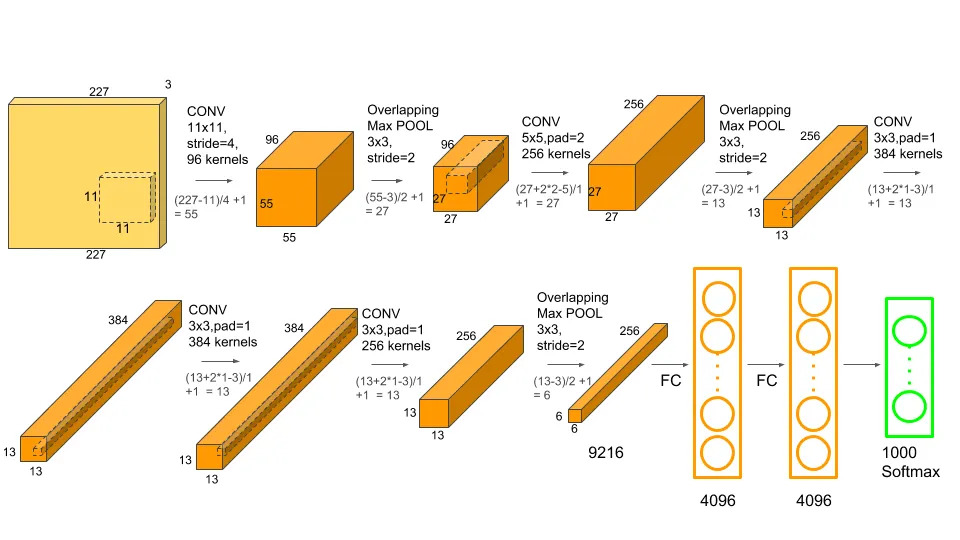

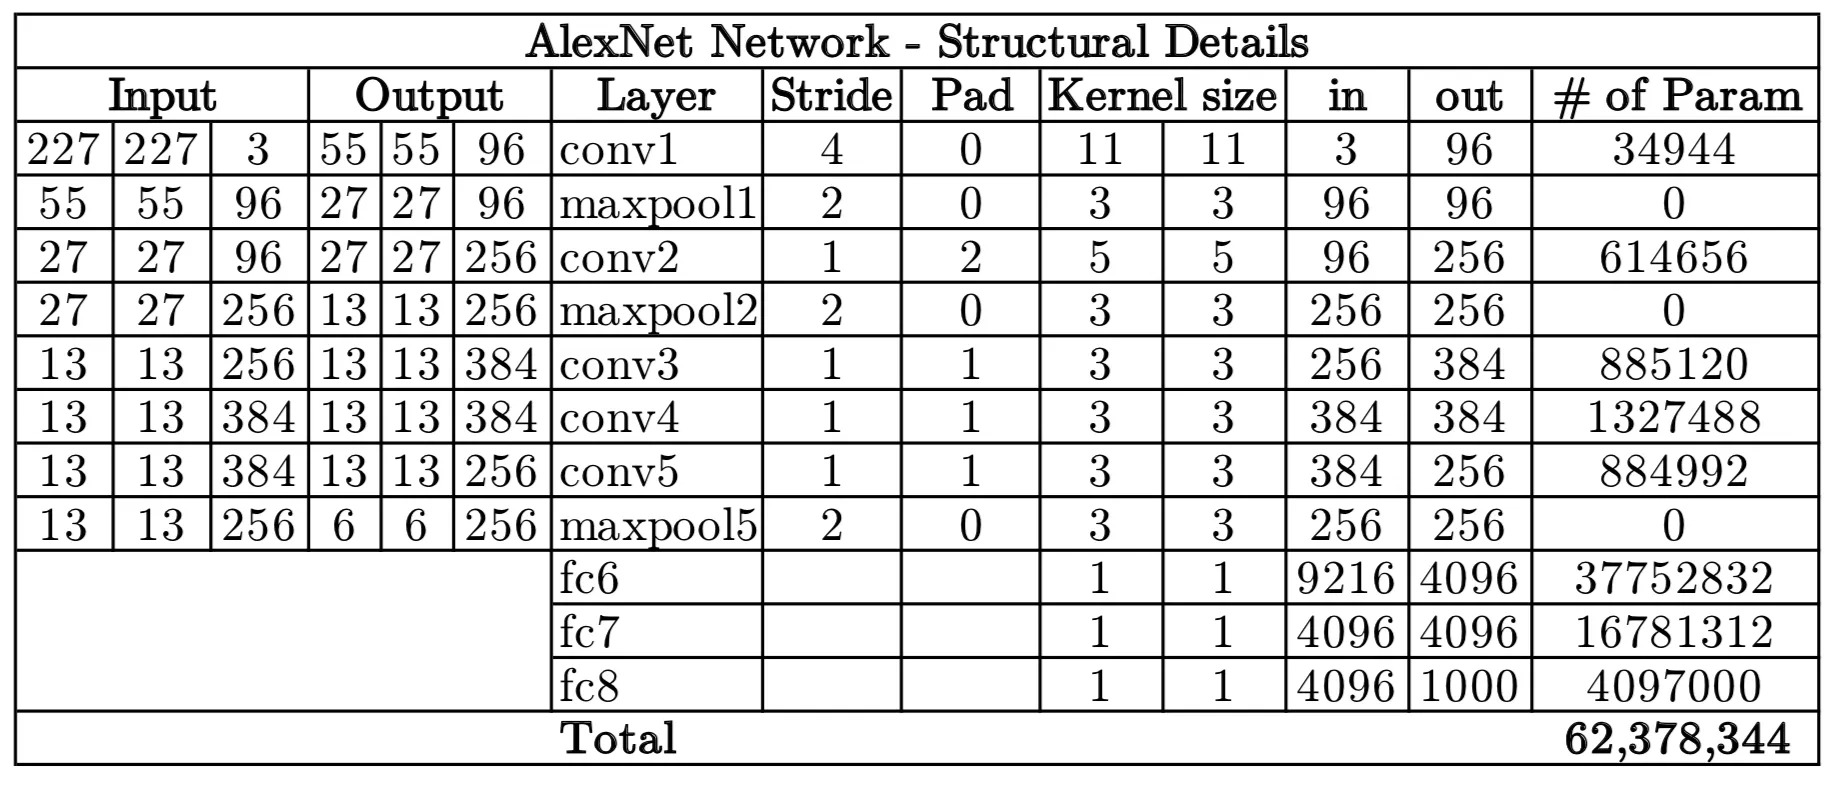

The entire network is composed of approximately 62 million trainable parameters that work in harmony to deliver astounding results.

## Key Features

### ReLU Nonlinearity 
AlexNet changed the sigmoid activation function to a simpler ReLU activation function. On the one hand, the computation of the ReLU activation function is simpler. For example, it does not have the exponentiation operation found in the sigmoid activation function. On the other hand, the ReLU activation function makes model training easier when using different parameter initialization methods. This is because, when the output of the sigmoid activation function is very close to 0 or 1, the gradient of these regions is almost 0, so that backpropagation cannot continue to update some of the model parameters. By contrast, the gradient of the ReLU activation function in the positive interval is always 1. Therefore, if the model parameters are not properly initialized, the sigmoid function may obtain a gradient of almost 0 in the positive interval, meaning that the model cannot be effectively trained.
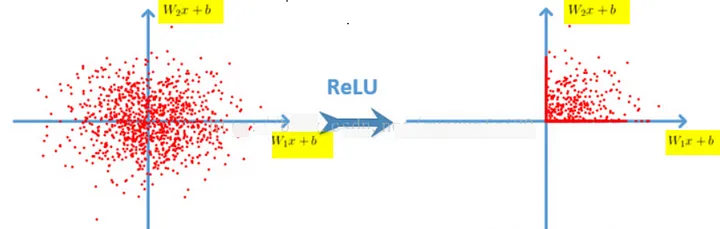

### Overlapping Max Pooling

To down-sample an image or a representation, Max Pool is used. It reduces its dimensionality by allowing assumptions to be made about features contained in the sub-regions binned. 

Overlapping Max Pool layers are similar to Max Pool layers except the adjacent windows over which the max is calculated overlaps each other. The authors of AlexNet used pooling windows, sized 3×3 with a stride of 2 between the adjacent windows. Due to this overlapping nature of Max Pool, the top-1 error rate was reduced by 0.4% and top-5 error rate was reduced by 0.3% respectively. If you compare this to using a non-overlapping pooling windows of size 2×2 with a stride of 2, that would give the same output dimensions.
we use non-overlapping pooling, like this:
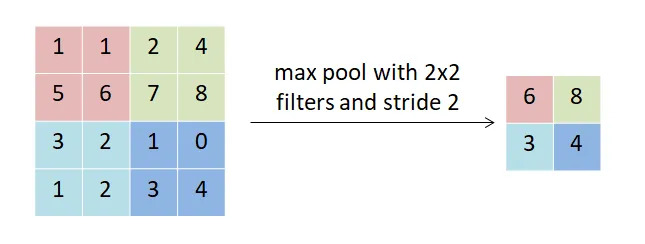
in AlexNet, overlapping pooling was used:

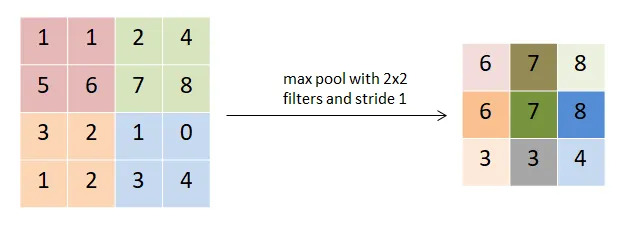

### Data Augmentation 

When you show a Neural Net different variation of the same image, it helps prevent overfitting. It also forces the Neural Net to memorize the key features and helps in generating additional data. 

#### Data Augmentation by Mirroring

Let’s say we have an image of a cat in our training set. The mirror image is also a valid image of a cat. This mean that we can double the size of the training datasets by simply flipping the image above the vertical axis.

#### Data Augmentation by Random Crops

Also, cropping the original image randomly will lead to additional data that is just a shifted version of the original data.

The authors of AlexNet extracted random crops sized 227×227 from inside the 256×256 image boundary, and used this as the network’s inputs. Using this method, they increased the size of the data by a factor of 2048.

### Dropout

During dropout, a neuron is dropped from the Neural Network with a probability of 0.5. When a neuron is dropped, it does not contribute to forward propagation or backward propagation. Every input goes through a different Neural Network architecture, as shown in the image below. As a result, the learned weight parameters are more robust and do not get overfitted easily.

In [10]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer5 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(9216, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

Let's dive into how the above code works:

* The first step to defining any neural network (whether a CNN or not) in PyTorch is to define a class that inherits nn.Module as it contains many of the methods that we will need to utilize
* There are two main steps after that. First is initializing the layers that we are going to use in our CNN inside __init__ , and the other is to define the sequence in which those layers will process the image. This is defined inside the forward function
* For the architecture itself, we first define the convolutional layers using the nn.Conv2D function with the appropriate kernel size and the input/output channels. We also apply max pooling using nn.MaxPool2D function. The nice thing about PyTorch is that we can combine the convolutional layer, activation function, and max pooling into one single layer (they will be separately applied, but it helps with organization) using the nn.Sequential function
* Then we define the fully connected layers using linear (nn.Linear) and dropout (nn.Dropout) along with ReLu activation function (nn.ReLU) and combining these with the nn.Sequential function
* Finally, our last layer outputs 10 neurons which are our final predictions for the 10 classes of objects

### Setting Hyperparameters

In [11]:
num_classes = 10
num_epochs = 20
learning_rate = 0.005

model = AlexNet(num_classes).to(device)

In [12]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)  
# Train the model
total_step = len(train_loader)

In [13]:
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
            
    # Validation
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del images, labels, outputs
    
        print('Accuracy of the network on the {} validation images: {} %'.format(5000, 100 * correct / total)) 

Epoch [1/20], Step [704/704], Loss: 0.8380
Accuracy of the network on the 5000 validation images: 59.6 %
Epoch [2/20], Step [704/704], Loss: 1.1044
Accuracy of the network on the 5000 validation images: 67.26 %
Epoch [3/20], Step [704/704], Loss: 0.8888
Accuracy of the network on the 5000 validation images: 72.75 %
Epoch [4/20], Step [704/704], Loss: 0.9823
Accuracy of the network on the 5000 validation images: 74.9 %
Epoch [5/20], Step [704/704], Loss: 1.3616
Accuracy of the network on the 5000 validation images: 75.98 %
Epoch [6/20], Step [704/704], Loss: 0.8530
Accuracy of the network on the 5000 validation images: 75.86 %
Epoch [7/20], Step [704/704], Loss: 0.6670
Accuracy of the network on the 5000 validation images: 79.62 %
Epoch [8/20], Step [704/704], Loss: 1.4178
Accuracy of the network on the 5000 validation images: 76.81 %
Epoch [9/20], Step [704/704], Loss: 0.6157
Accuracy of the network on the 5000 validation images: 79.73 %
Epoch [10/20], Step [704/704], Loss: 1.1166
Accu

Let's see what the code does:

* We start by iterating through the number of epochs, and then the batches in our training data
* We convert the images and the labels according to the device we are using, i.e., GPU or CPU
* In the forward pass, we make predictions using our model and calculate loss based on those predictions and our actual labels
* Next, we do the backward pass where we actually update our weights to improve our model
* We then set the gradients to zero before every update using optimizer.zero_grad() function
* Then, we calculate the new gradients using the loss.backward() function
* And finally, we update the weights with the optimizer.step() function
* Also, at the end of every epoch we use our validation set to calculate the accuracy of the model as well. In this case, we don't need gradients so we use with torch.no_grad() for faster evaluation

In [14]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        del images, labels, outputs

    print('Accuracy of the network on the {} test images: {} %'.format(10000, 100 * correct / total))

Accuracy of the network on the 10000 test images: 81.51 %


In [15]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 79 %
Accuracy of   car : 92 %
Accuracy of  bird : 84 %
Accuracy of   cat : 72 %
Accuracy of  deer : 76 %
Accuracy of   dog : 71 %
Accuracy of  frog : 81 %
Accuracy of horse : 80 %
Accuracy of  ship : 87 %
Accuracy of truck : 84 %
